In [2]:
from prefect import task, Flow
from prefect.engine.results import LocalResult
import rad_pipeline.zipcodes as zc
import rad_pipeline.rad_pipeline as rp
import great_expectations as ge
import datacompy
import os

In [3]:
import importlib
importlib.reload(rp)
importlib.reload(zc)

<module 'rad_pipeline.zipcodes' from '/Users/alexhasha/repos/massenergize/rad_pipeline/rad_pipeline/zipcodes.py'>

In [4]:
os.getcwd()

'/Users/alexhasha/repos/massenergize/rad_pipeline/notebooks'

In [5]:
#TODO: Figure out how to get intermediate results cached for quick pipeline rerun on failure

load_ashp = task(rp.load_ashp, result=LocalResult(), target="{flow_run_id}/{scheduled_start_time:%Y-%d-%m}/load_ashp.pkl")
data_clean = task(rp.data_clean, result=LocalResult(), target="{flow_run_id}/{scheduled_start_time:%Y-%d-%m}/clean_ashp.pkl")
data_checkpoint = task(rp.data_checkpoint, result=LocalResult(), target="{flow_run_id}/{scheduled_start_time:%Y-%d-%m}/checkpoint_ashp.pkl")
dq_check = task(rp.dq_check)
clean_data_load = task(rp.clean_data_load)

In [6]:
@task
def verify_equal(df, from_disk):
    compare = datacompy.Compare(
        df,
        from_disk,
        on_index=True,
        abs_tol=1e-5, #Optional, defaults to 0
        rel_tol=1e-5, #Optional, defaults to 0
        df1_name='In Memory', #Optional, defaults to 'df1'
        df2_name='From Disk' #Optional, defaults to 'df2'
    )
    if not compare.matches(ignore_extra_columns=False):
        print(compare.report())
        raise ValueError("Reload from disk mismatch")
    
    return compare

## ASHP

In [ ]:
with Flow("RAD pipeline: ASHP") as flow:
    source = "Air-source Heat Pumps"
    ashp = load_ashp()
    dq_check(ashp, source, "raw")
    ashp_cleaned = data_clean(ashp, source)
    ashp_checkpointed = data_checkpoint(
        ashp_cleaned,
        "Air-source Heat Pumps"
    )
    
    ashp_from_disk = clean_data_load(source)
    dq_check(ashp_from_disk, source, "clean")
    ashp_from_disk.set_upstream(ashp_checkpointed, flow=flow)
    verify_equal(ashp_checkpointed, ashp_from_disk)

In [ ]:
flow.visualize()

In [ ]:
flow_state = flow.run()

In [ ]:
flow.visualize(flow_state=flow_state)

### Inspecting task results

In [ ]:
tasks = flow.get_tasks()
tasks

In [ ]:
ashp_cleaned_df = flow_state.result[tasks[3]]._result.value

In [ ]:
ashp_cleaned_df.shape

# GHSP

In [7]:
load_gshp = task(rp.load_gshp, 
                  result=LocalResult(), 
                  target="flows/{scheduled_start_time:%Y-%d-%m}/load_solar.pkl")

In [8]:
with Flow("RAD pipeline: GSHP") as flow:
    source = "Ground-source Heat Pumps"
    gshp = load_gshp()
    dq_check(gshp, source, "raw")
    gshp_cleaned = data_clean(gshp, source)
    gshp_checkpointed = data_checkpoint(
        gshp_cleaned,
        "Ground-source Heat Pumps"
    )
    
    gshp_from_disk = clean_data_load(source)
    dq_check(gshp_from_disk, source, "clean")
    gshp_from_disk.set_upstream(gshp_checkpointed, flow=flow)
    verify_equal(gshp_checkpointed, gshp_from_disk)

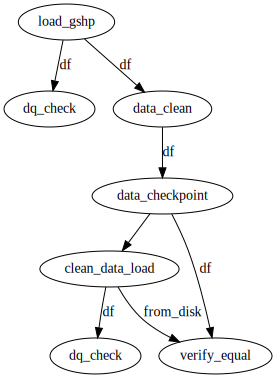

In [9]:
flow.visualize()

In [10]:
flow_state = flow.run()

[2021-03-22 09:38:13-0400] INFO - prefect.FlowRunner | Beginning Flow run for 'RAD pipeline: GSHP'
[2021-03-22 09:38:13-0400] INFO - prefect.TaskRunner | Task 'load_gshp': Starting task run...
[2021-03-22 09:38:14-0400] INFO - prefect.TaskRunner | Task 'load_gshp': Finished task run for task with final state: 'Success'
[2021-03-22 09:38:14-0400] INFO - prefect.TaskRunner | Task 'data_clean': Starting task run...
[2021-03-22 09:38:33-0400] INFO - prefect.TaskRunner | Task 'data_clean': Finished task run for task with final state: 'Success'
[2021-03-22 09:38:33-0400] INFO - prefect.TaskRunner | Task 'data_checkpoint': Starting task run...
[2021-03-22 09:38:33-0400] INFO - prefect.TaskRunner | Task 'data_checkpoint': Finished task run for task with final state: 'Success'
[2021-03-22 09:38:33-0400] INFO - prefect.TaskRunner | Task 'clean_data_load': Starting task run...
[2021-03-22 09:38:33-0400] INFO - prefect.TaskRunner | Task 'clean_data_load': Finished task run for task with final stat

[2021-03-22 09:38:33-0400] INFO - prefect.TaskRunner | Task 'verify_equal': Starting task run...
[2021-03-22 09:38:33-0400] INFO - prefect.TaskRunner | Task 'verify_equal': Finished task run for task with final state: 'Success'
[2021-03-22 09:38:33-0400] INFO - prefect.FlowRunner | Flow run SUCCESS: all reference tasks succeeded


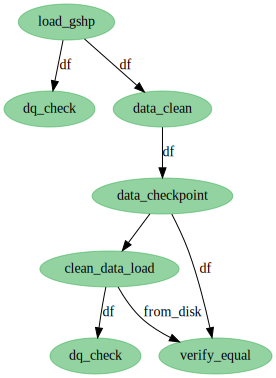

In [11]:
flow.visualize(flow_state=flow_state)

## Solar Panels

In [ ]:
load_solar = task(rp.load_solar, 
                  result=LocalResult(), 
                  target="flows/{scheduled_start_time:%Y-%d-%m}/load_solar.pkl")

In [ ]:
with Flow("RAD pipeline: Solar Panels") as flow:
    source = "Solar Panels"
    solar = load_solar()
    dq_check(solar, source, "raw")
    solar_cleaned = data_clean(solar, source)
    solar_checkpointed = data_checkpoint(
        solar_cleaned,
        "Solar Panels"
    )
    
    solar_from_disk = clean_data_load(source)
    dq_check(solar_from_disk, source, "clean")
    solar_from_disk.set_upstream(solar_checkpointed, flow=flow)
    verify_equal(solar_checkpointed, solar_from_disk)

In [ ]:
flow.visualize()

In [ ]:
flow_state = flow.run()

In [ ]:
flow.visualize(flow_state=flow_state)